In [ ]:
import numpy as np
from Simulation.Motion import State, GPS, Drive
from matplotlib import pyplot as plt

bot_spec = {'wheelbase': 0.235,
            'wheel_velocity_range': [-0.5,0.5], # m/s, [min max]
            'min_wheel_speed': 0.0,
            'wheel_diameter': 0.072,
            'body_radius': 0.175,
            'wheelbase_offset': 0.0,
            'wheel_velocity_var': 0.0,r
            #'steering_var': 1e-3, # not yet implemented
            'abs_min_turning_radius': 0.0,
            'L2R_bias_mean': 1.0,                                                                                                                                             
            'L2R_bias_var': 0.0,                                                                                                                                              
            'velo_var': 0.0,                                                                                                                                                 
            'heading_offset_mean': 0.0,                                                                                                                                  
            'heading_offset_var': 0.0}
%matplotlib inline

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from Control import DubinsPath

In [3]:
start_pose = np.array([5.0,5.0, np.pi])
goal_pose = np.array([-5., -5.0, np.pi])
min_turn_radius = 10.0
course, inter_poses, _,_ = DubinsPath.generate_course(start_pose, goal_pose, min_turn_radius, speed=0.1, dt=0.1)

In [4]:
from Animation import Render

(123, 2)


<IPython.core.display.Javascript object>


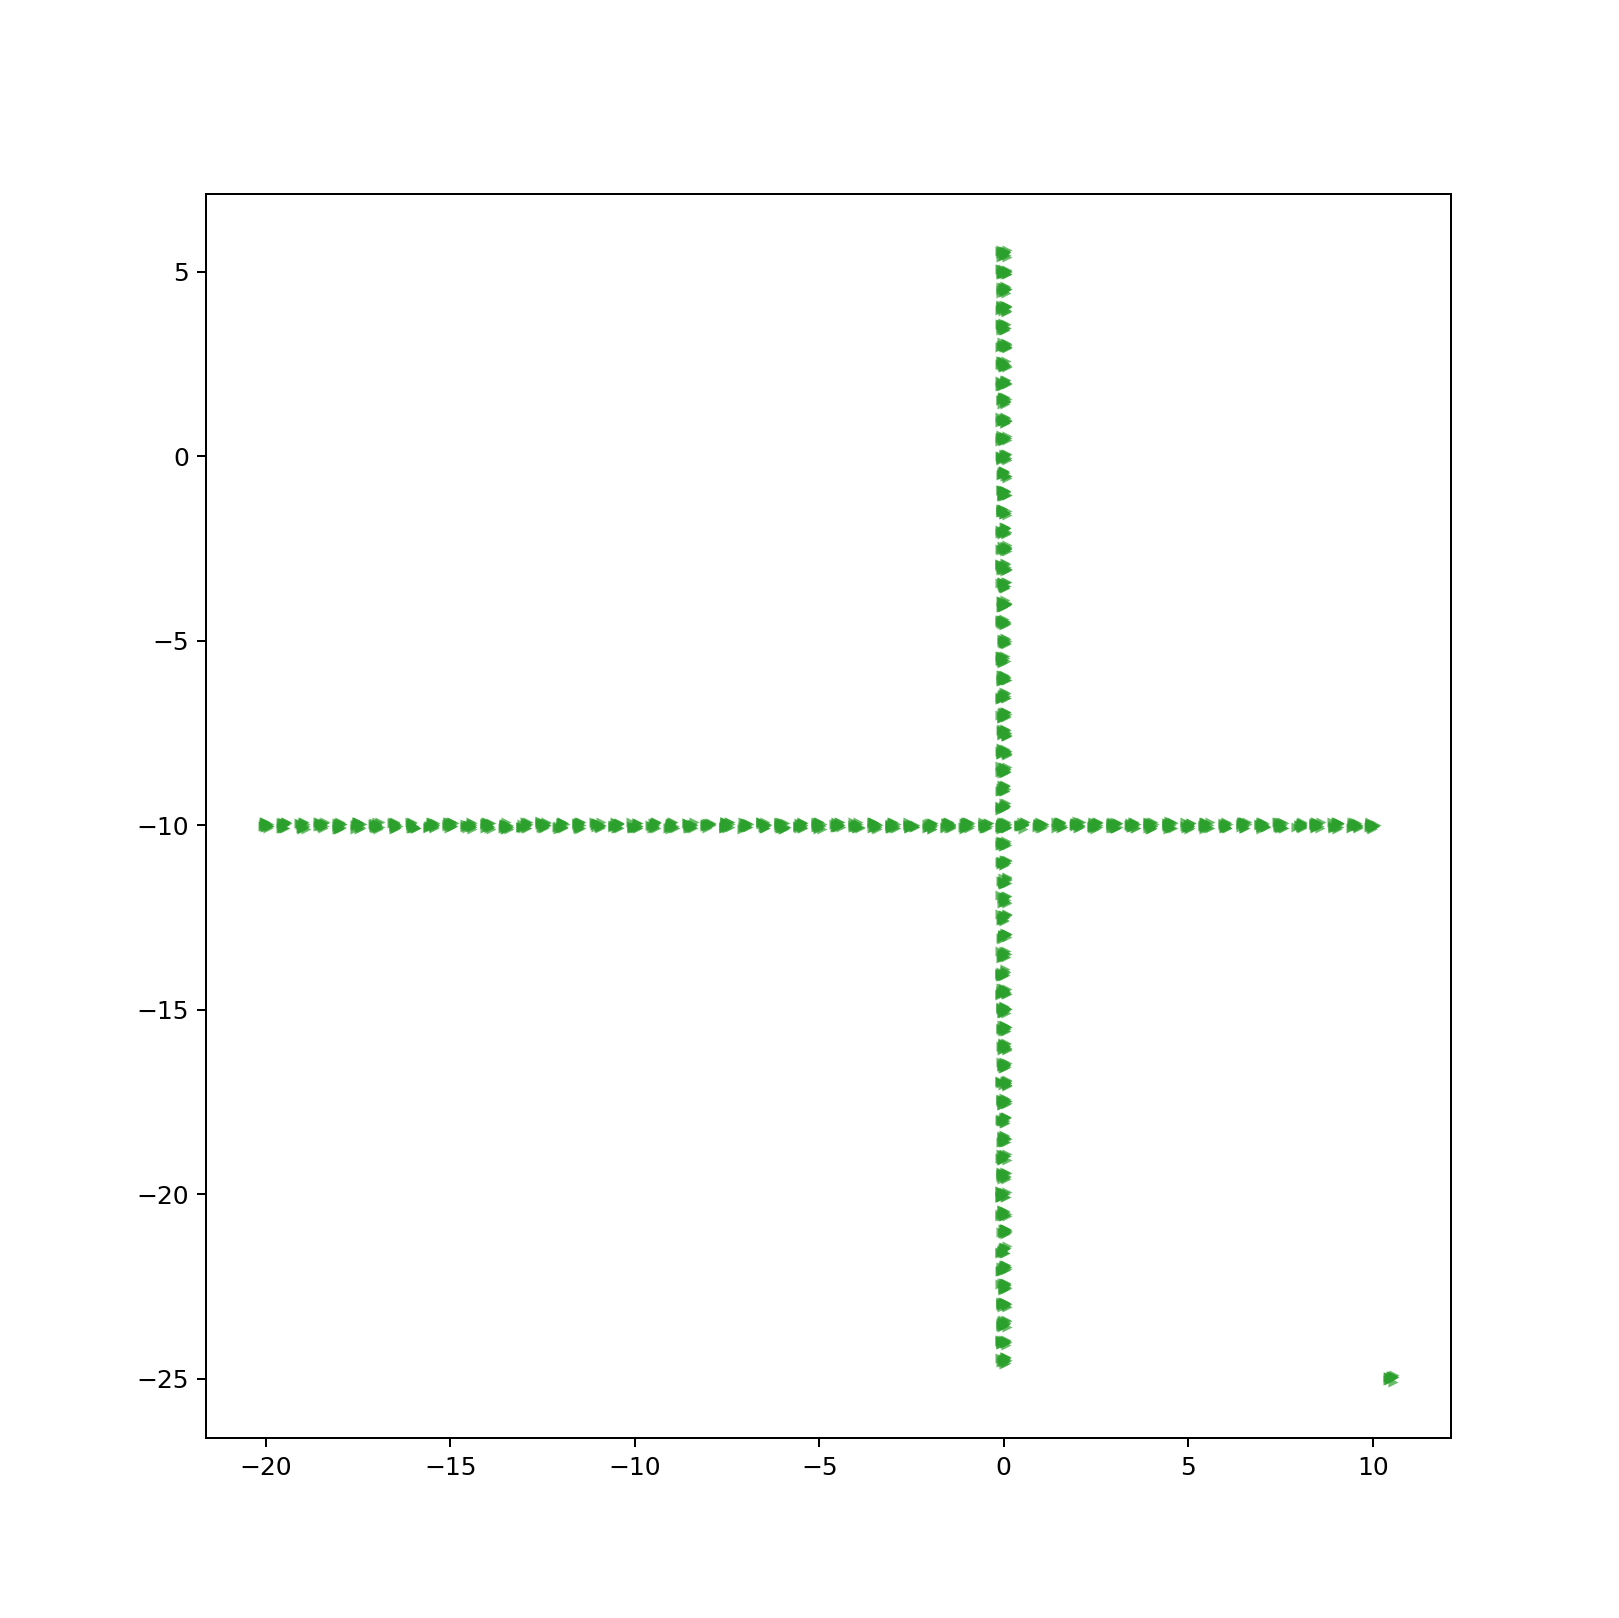

TypeError: cannot unpack non-iterable PathCollection object

In [5]:
walls = np.hstack(( np.hstack((np.arange(-20,11, 0.5),np.zeros(61))).reshape(-1,1) ,
                    np.hstack((-10*np.ones(61),np.arange(-25, 6, 0.5))).reshape(-1,1)  ))
print(walls.shape)
foods = np.array([5.,-5., 5., -15.]).reshape(2,2)

objs = {'agent': course, 'food': foods, 'plant': walls}
image = Render.StillImage(figsize=5)
image.render(objs)
image.fig.show()

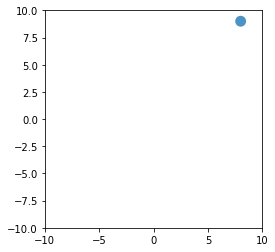

In [23]:
%matplotlib inline
import time
xx = np.arange(10).reshape(5,2)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.add_artist(plt.Circle(xx[0],0.5, alpha=0.8))
for i in range(5):
    ax1.clear()
    ax1.add_artist(plt.Circle(xx[i],0.5, alpha=0.8))
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.set_aspect('equal')

In [ ]:
checkpoints = np.vstack((start_pose, 
                         inter_poses['A'],
                         inter_poses['B'], 
                         goal_pose
                        ))

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
agent._course(ax,course)
agent._quiver(ax,course[::200])

In [ ]:
walls = np.array([0.,-4.,0.,-5]).reshape(2,2)
foods = np.array([5.,-5., 5., -15.]).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
agent._course(ax,course)
agent._quiver(ax,course[::200])
plant.plot(ax, walls)
food.plot(ax,foods)

In [ ]:
np.hstack((np.arange(-10,11,0.01).reshape(-1,1),np.arange(-20,1,0.01).reshape(-1,1))).shape

In [ ]:
xx = np.ones((10,3))

In [ ]:
xx[:,:2].shape

In [ ]:
mkls = '<>v^1234'

In [ ]:
mkls[1]

In [ ]:
from math import acos

In [ ]:
acos(1/1)

In [ ]:
np.arccos(1/0.9)

In [ ]:
float('inf') + float('inf')

In [ ]:
checkpoints = np.vstack((start_pose, 
                         inter_poses['A'],
                         inter_poses['B'], 
                         goal_pose
                        ))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(course[:,0], course[:,1])
arrow_length = 1
bbox = ax.get_window_extent()
print(bbox.width, bbox.height)

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
xrange = ax.get_xlim()[1] - ax.get_xlim()[0]

scale = ax.get_window_extent().width/xrange
print(scale)
ax.scatter(checkpoints[:,0], checkpoints[:,1], s=0.7*scale)
ax.quiver(checkpoints[:,0],checkpoints[:,1],
           arrow_length*np.cos(checkpoints[:,2]),arrow_length*np.sin(checkpoints[:,2]),
           pivot='tail',scale_units='xy',scale=1.0,width=0.007*arrow_length,color='tab:red')
ax.set_aspect('equal')

In [ ]:
ax.get_yrange()

## Self-corrected Dubins Path with noisy GPS

### 1. Dubins Path Planning

In [ ]:
from math import sin, cos, atan2, sqrt, acos, pi, hypot

In [ ]:
def wrap_to_pi(a):
    if a >= pi:
        a -= 2*pi
    elif a < -pi:
        a += 2*pi
    return a

In [ ]:
def plan(start_pose, goal_pose, min_turn_radius, selected_path_types=None):
    if selected_path_types is None:
        path_funcs = _DUBINS_PATH_TYPES.values()
    else:
        path_funcs = [_DUBINS_PATH_TYPES[path_type] for path_type in selected_path_types]
    best_cost = float('inf')
    best_inter_poses, best_modes = None, None
    for plan in path_funcs:
        inter_poses, distances, modes = plan(start_pose, goal_pose, min_turn_radius)
        cost = sum(distances)
        if best_cost > cost:
            best_inter_poses, best_distances, best_modes, best_cost = inter_poses, distances, modes, cost

    return best_inter_poses, best_distances, best_modes
          
    
def _LSL(start_pose, goal_pose, min_turn_radius):
    modes = ['L','S','L']    
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]+pi/2),sin(start_pose[2]+pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]+pi/2), sin(goal_pose[2]+pi/2)])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    A = C1 + r*np.array([cos(yaw_C2C1 - pi/2), sin(yaw_C2C1 - pi/2)])
    B = C2 + r*np.array([cos(yaw_C2C1 - pi/2), sin(yaw_C2C1 - pi/2)])
    A_pose = np.append(A, yaw_C2C1)
    B_pose = np.append(B, yaw_C2C1)
    
    theta1 = abs(wrap_to_pi(A_pose[2]-start_pose[2]))
    theta1 = 2*pi - theta1 if wrap_to_pi(A_pose[2]-start_pose[2]) < 0 else theta1
    #theta2 = 0.0
    theta3 =  abs(wrap_to_pi(goal_pose[2]-B_pose[2]))
    theta3 = 2*pi - theta3 if wrap_to_pi(goal_pose[2]-B_pose[2]) < 0 else theta3
    
    d1 = theta1*r
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = theta3*r
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distances = [d1,d2,d3]
    
    return inter_poses, distances, modes, 

def _LSR(start_pose, goal_pose, min_turn_radius):
    modes = ['L','S','R']    
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]+pi/2),sin(start_pose[2]+pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]-pi/2), sin(goal_pose[2]-pi/2)])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    
    alpha = acos(2*r/ hypot(C2[1]-C1[1], C2[0]-C1[0]))
    
    A = C1 + r*np.array([cos(yaw_C2C1 - alpha), sin(yaw_C2C1 - alpha)])
    B = C2 + r*np.array([cos(yaw_C2C1 - alpha + pi), sin(yaw_C2C1 +  - alpha + pi)])
    A_pose = np.append(A, wrap_to_pi(yaw_C2C1 - alpha + pi/2))
    B_pose = np.append(B, wrap_to_pi(yaw_C2C1 - alpha + pi/2))
    
    
    theta1 = abs(wrap_to_pi(A_pose[2]-start_pose[2]))
    theta1 = 2*pi - theta1 if wrap_to_pi(A_pose[2]-start_pose[2]) < 0 else theta1
    #theta2 = 0.0
    theta3 =  abs(wrap_to_pi(goal_pose[2]-B_pose[2]))
    theta3 = 2*pi - theta3 if wrap_to_pi(goal_pose[2]-B_pose[2]) > 0 else theta3
    
    d1 = theta1*r
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = theta3*r
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distances = [d1,d2,d3]
    
    return inter_poses, distances, modes, 


def _RSL(start_pose, goal_pose, min_turn_radius):
    modes = ['R','S','L']    
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]-pi/2),sin(start_pose[2]-pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]+pi/2), sin(goal_pose[2]+pi/2)])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    
    alpha = acos(2*r/ hypot(C2[1]-C1[1], C2[0]-C1[0]))
    
    A = C1 + r*np.array([cos(yaw_C2C1 + alpha), sin(yaw_C2C1 + alpha)])
    B = C2 + r*np.array([cos(yaw_C2C1 + alpha - pi), sin(yaw_C2C1 + alpha - pi)])
    A_pose = np.append(A, wrap_to_pi(yaw_C2C1 + alpha - pi/2))
    B_pose = np.append(B, wrap_to_pi(yaw_C2C1 + alpha - pi/2))
    
    
    theta1 = abs(wrap_to_pi(A_pose[2]-start_pose[2]))
    theta1 = 2*pi - theta1 if wrap_to_pi(A_pose[2]-start_pose[2]) > 0 else theta1
    #theta2 = 0.0
    theta3 =  abs(wrap_to_pi(goal_pose[2]-B_pose[2]))
    theta3 = 2*pi - theta3 if wrap_to_pi(goal_pose[2]-B_pose[2]) < 0 else theta3
    
    d1 = theta1*r
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = theta3*r
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distances = [d1,d2,d3]
    
    return inter_poses, distances, modes, 


def _RSR(start_pose, goal_pose, min_turn_radius):
    modes = ['R','S','R']
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]-pi/2),sin(start_pose[2]-pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]-pi/2), sin(goal_pose[2]-pi/2)])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    A = C1 + r*np.array([cos(yaw_C2C1 + pi/2), sin(yaw_C2C1 + pi/2)])
    B = C2 + r*np.array([cos(yaw_C2C1 + pi/2), sin(yaw_C2C1 + pi/2)])
    A_pose = np.append(A, yaw_C2C1)
    B_pose = np.append(B, yaw_C2C1)
    
    theta1 = abs(wrap_to_pi(A_pose[2]-start_pose[2]))
    theta1 = 2*pi - theta1 if wrap_to_pi(A_pose[2]-start_pose[2]) > 0 else theta1
    #theta2 = 0.0
    theta3 =  abs(wrap_to_pi(goal_pose[2]-B_pose[2]))
    theta3 = 2*pi - theta3 if wrap_to_pi(goal_pose[2]-B_pose[2]) > 0 else theta3
    
    d1 = theta1*r
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = theta3*r
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distances = [d1,d2,d3]
    
    return inter_poses, distances, modes


_DUBINS_PATH_TYPES = {'LSL': _LSL, 'LSR': _LSR, 'RSL': _RSL, 'RSR': _RSR, }


    
    

In [ ]:
start_pose = np.array([0.0,0.0, -pi/2])
goal_pose = np.array([-5., 10.5, -3*pi/4])
min_turn_radius = 2.0
inter_poses, distances, modes = plan(start_pose = start_pose, goal_pose = goal_pose, min_turn_radius=min_turn_radius)

In [ ]:
print(inter_poses)
print(distances)
print(modes)

In [ ]:
def generate_course(start_pose, distances, modes, min_turn_radius, speed=0.1, dt=0.01):
    state = State(pose=start_pose, kinematic = [speed, 0.0], dt=dt)
    course = start_pose.reshape(1,3)
    w = speed/min_turn_radius
    for i in range(3):
        dist = 0
        while dist < distances[i]:
            omega = w if modes[i]=='L' else -w if modes[i]=='R' else 0.0
            state.update_kinematic(new_w = omega)
            state.update_pose()
            dist += min_turn_radius*w*dt
            course = np.vstack((poses, state.pose))
    return course
    

In [ ]:
poses = generate_path(start_pose, distances=distances, modes=modes, min_turn_radius=min_turn_radius)

In [ ]:
checkpoints = np.vstack((start_pose, 
                         inter_poses['A'], 
                         inter_poses['B'], 
                         goal_pose
                        ))

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(poses[:,0], poses[:,1])

ax.scatter(checkpoints[:,0],checkpoints[:,1])
ax.quiver(checkpoints[:,0],checkpoints[:,1],
           0.175*np.cos(checkpoints[:,2]),0.175*np.sin(checkpoints[:,2]),
           pivot='tail',scale_units='xy',scale=0.15,width=0.01,color='b')
ax.set_aspect('equal')

In [ ]:
distances

In [ ]:
state2 = State(pose=[0.0,0.0,0.0], kinematic = [0.1, 0.0], dt = 0.5)

In [ ]:
state2.reset()

In [ ]:
state2.reset()
sim_len = 500
poses = np.zeros((sim_len,3))
Rs = np.zeros(sim_len)
ICCs = np.zeros((sim_len,2))
kinematics = np.zeros((sim_len,2))
for i in range(sim_len):
    kinematics[i] = np.array(state2.kinematic)
    Rs[i] = state2.turning_radius()
    ICCs[i] = np.array(state2.ICC())
    state2.update_pose()
    poses[i] = state2.pose
    if i>91 and i<110:
        state2.update_kinematic(new_w = np.pi/18)
    elif i>182 and i<219:
        state2.update_kinematic(new_w = np.pi/36)
    elif i>300 and i<310:
        state2.update_kinematic(new_w = np.pi/9)
    elif i>400 and i<418:
        state2.update_kinematic(new_w = np.pi/17)
    else:
        state2.update_kinematic(new_w = 0.0)
        

In [ ]:
state = State(pose=[0.0,0.0,0.0], kinematic = [0.1, 0.0], dt = 0.5)
gps = GPS(pose = [0.0, 0.0, 0.0], noise = True, mode='create', custom_spec=bot_spec)
drive = Drive(custom=True,custom_spec=bot_spec,noise=True)

In [ ]:
state.reset()
drive.reset()
sim_len = len(kinematics)
poses_hat = np.zeros((sim_len,3))
kinematics_hat = np.zeros((sim_len,2))
state2.pose = gps.pose_hat
poses2_hat = np.zeros((sim_len,3))
for i, kine in enumerate(kinematics):
    drive.kinematic_update(kine)
    #print(kine)
    #print(drive.kinematic)
    state.update_kinematic(drive.kinematic)
    state.update_pose()
    gps.update(state.pose)
    poses_hat[i]=state.pose
    poses2_hat[i]=gps.pose_hat
    kinematics_hat[i]=state.kinematic
    

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(poses[:,0], poses[:,1])
ax.plot(poses_hat[:,0], poses_hat[:,1])
ax.plot(poses2_hat[:,0], poses2_hat[:,1])
ax.set_aspect('equal')


In [ ]:
%matplotlib notebook

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

plt.quiver(poses_hat[:,0],poses_hat[:,1],
           0.175*np.cos(poses_hat[:,2]),0.175*np.sin(poses_hat[:,2]),
           pivot='tail',scale_units='xy',scale=0.5,width=0.01,color='b',alpha=0.5)
plt.quiver(poses2_hat[:,0],poses2_hat[:,1],
           0.175*np.cos(poses2_hat[:,2]),0.175*np.sin(poses2_hat[:,2]),
           pivot='tail',scale_units='xy',scale=1,width=0.01,color='g',alpha=0.5)
ax.set_aspect('equal')


In [ ]:
poses2_hat

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].plot(kinematics[:,0])
ax[0].plot(kinematics_hat[:,0])
ax[1].plot(kinematics[:,1])
ax[1].plot(kinematics_hat[:,1])


In [ ]:
members = [attr for attr in vars(drive.bot) if not callable(getattr(drive.bot, attr)) and not attr.startswith("__")]
print(members)

In [ ]:
for attr in members:
    print(attr,'\t|\t', getattr(drive.bot, attr))